### ECE 276 Assignment 4 : Deep Deterministic Policy Gradients

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gym
import pybullet
import pybulletgym.envs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
 
import matplotlib.pyplot as plt
 
from collections import deque
import numpy as np
import random
import time
import copy
import pickle

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [3]:
def weighSync(target_model, source_model, tau=0.001):
    '''
    A function to soft update target networks
    '''
    for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + source_param.data * tau)  

In [4]:
class Replay():
    def __init__(self, buffer_size, init_length, state_dim, action_dim, env):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        self.buffer_size = buffer_size  
        self.init_length = init_length  
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.env = env

        self._buffer = deque()  

        if self.env is not None:    
            self.init_test()
            
    def init_test(self):
        
        count = 0
        flag = False
        while not flag:
            done = False
            state = self.env.reset()
            step = 1
            while not done:
                action = self.env.action_space.sample()     # sample random action
                state_next, reward, done, info = self.env.step(action)
                step += 1

                dic = {'state': state,
                       'action': action,
                       'reward': reward,
                       'state_next': state_next,
                       'done': done}
                if step == 150:
                    dic['done'] = False      # NOTE: 150 is not done
                self.buffer_add(dic)

                state = state_next
                count += 1

                if count >= self.init_length:
                    flag = True
                    break

    
    def buffer_add(self, exp):
        """
        A function to add a dictionary to the buffer
        :param exp : A dictionary consisting of state, action, reward , next state and done flag
        """
        
        self._buffer.append(exp)

        if len(self._buffer) > self.buffer_size:
            self._buffer.popleft()

    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        :param N : Number of samples to obtain from the buffer
        """
        return random.sample(self._buffer, N)


In [5]:
class Actor(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        """
        Initialize the network
        :param state_dim : Size of the state space
        :param action_dim: Size of the action space
        """
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim


        self.layer_1 = nn.Linear(self.state_dim, 400)
        

        self.layer_2 = nn.Linear(400, 300)
        

        self.layer_3 = nn.Linear(300, self.action_dim)

        
        self.layer_1.weight.data.uniform_(-1/np.sqrt(self.state_dim), 1/np.sqrt(self.state_dim))
        self.layer_1.weight.data.uniform_(-1/np.sqrt(400),1/np.sqrt(400))
        self.layer_3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """
        Define the forward pass
        param: state: The state of the environment
        """
        if isinstance(state, np.ndarray):
            x = torch.FloatTensor(state)
        else:
            x = state
            
        x = self.layer_1(x)
        x = F.relu(x)

        x = self.layer_2(x)
        x = F.relu(x)

        x = self.layer_3(x)
        x = torch.tanh(x)
        return x

In [6]:
class Critic(nn.Module):

    def __init__(self, state_dim, action_dim):
        """
        Initialize the critic
        :param state_dim : Size of the state space
        :param action_dim : Size of the action space
        """
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim


        self.layer_1 = nn.Linear(self.state_dim, 400)
        self.layer_2 = nn.Linear(400 + self.action_dim, 300)
        self.layer_3 = nn.Linear(300, 1)

        self.layer_1.weight.data.uniform_(-1/np.sqrt(self.state_dim), 1/np.sqrt(self.state_dim))
        self.layer_2.weight.data.uniform_(-1/np.sqrt(400 + self.action_dim), 1/np.sqrt(400 + self.action_dim))
        self.layer_3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Define the forward pass of the critic
        """
        if isinstance(state, np.ndarray):
            x = torch.FloatTensor(state)
        else:
            x = state
            
        if isinstance(action, np.ndarray):
            a = torch.FloatTensor(action)
        else:
            a = action
            
        x = self.layer_1(x)
        x = F.relu(x)
            
        x = torch.cat((x, a), 1)
        x = self.layer_2(x)
        x = F.relu(x)

        x = self.layer_3(x)
        return x

    

In [7]:
class DDPG():
    def __init__(
            self,
            env,
            state_dim,
            action_dim,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
    ):
        """
        :param env: An gym environment
        :param state_dim: Size of state space
        :param action_dim: Size of action space
        :param critic_lr: Learning rate of the critic
        :param actor_lr: Learning rate of the actor
        :param gamma: The discount factor
        :param batch_size: The batch size for training
        """
        self.gamma = gamma
        self.batch_size = batch_size
        self.env = env
        self.test_env = copy.deepcopy(env)  

        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.ReplayBuffer = Replay(buffer_size=10000,
                                   init_length=1000,
                                   state_dim=state_dim,
                                   action_dim=action_dim,
                                   env=env)

    def get_action(self, state):
        # noise with 0.1 variance
        noise = np.random.multivariate_normal(mean=[0, 0], cov=np.diag([0.1, 0.1]))
        action = self.actor(torch.FloatTensor(state).to(device)).cpu().detach().numpy() + noise 
        return np.clip(action, -1, 1)

    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)

    def update_network(self, batch):
        """
        A function to update the function just once
        """

        batch_size = len(batch)
        batch_state = []
        batch_action = []
        batch_reward = []
        batch_next_state = []
        batch_not_done = []
        
        
        for dic in batch:
            batch_state.append(torch.FloatTensor(dic['state']))
            batch_action.append(torch.FloatTensor(dic['action']))
            batch_reward.append(torch.FloatTensor([dic['reward']]))
            batch_next_state.append(torch.FloatTensor(dic['state_next']))
            batch_not_done.append(torch.FloatTensor([not dic['done']]))

        batch_state = torch.cat(batch_state).reshape(batch_size, -1).to(device)
        batch_action = torch.cat(batch_action).reshape(batch_size, -1).to(device)
        batch_reward = torch.cat(batch_reward).reshape(batch_size, -1).to(device)
        batch_next_state = torch.cat(batch_next_state).reshape(batch_size, -1).to(device)
        batch_not_done = torch.cat(batch_not_done).reshape(batch_size, -1).to(device)


        batch_next_action = self.actor_target.forward(batch_next_state)
        tar_Q = self.critic_target.forward(batch_next_state, batch_next_action)

        tar_Q = batch_reward + \
            (self.gamma * batch_not_done * tar_Q)

        current_Q = self.critic.forward(batch_state, batch_action)

        self.optimizer_critic.zero_grad()
        critic_loss = F.mse_loss(current_Q, tar_Q)
        critic_loss.backward()
        self.optimizer_critic.step()

        self.optimizer_actor.zero_grad()
        actor_loss = - self.critic(batch_state,
                                   self.actor(batch_state)).mean()
        actor_loss.backward()
        self.optimizer_actor.step()

        self.update_target_networks()

        return critic_loss.item(), actor_loss.item()

    def test_Pi_eval(self):
        state = self.test_env.reset()

        count = 0
        average_reward = 0
        done = False
        while not done:
            action = self.actor(torch.FloatTensor(state).to(
                device)).cpu().detach().squeeze().numpy()
            next_state, r, done, _ = self.test_env.step(action)
            state = next_state
            count += 1
            average_reward += r

        average_reward /= count
        
        return count, average_reward


    
    def train(self, num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps: The number of steps to train the policy for
        """
        time_start = time.time()

        critic_loss = []
        actor_loss = []
        eval_steps = []
        avg_reward = []
        traj_step = 1
        state = self.env.reset()

        for i in range(num_steps):
            
            action = self.get_action(state)
            state_next, reward, done, _ = self.env.step(action)     
            traj_step += 1

            dic = {'state': state,
                   'action': action,
                   'reward': reward,
                   'state_next': state_next,
                   'done': done}
            if traj_step == 150:
                dic['done'] = False      
            self.ReplayBuffer.buffer_add(dic)


            state = state_next

            if done:
                traj_step = 1
                state = self.env.reset()

            
            batch = self.ReplayBuffer.buffer_sample(self.batch_size)

            critic_loss_i, actor_loss_i = self.update_network(batch)

            critic_loss.append(critic_loss_i)
            actor_loss.append(actor_loss_i)

            if i % 100 == 0:
                
                eval_step, eval_average_reward = self.test_Pi_eval()
                eval_steps.append(eval_step)
                avg_reward.append(eval_average_reward)
                print('step {}, critic_loss = {:.4f}, actor_loss = {:.4f}'
                      .format(i, critic_loss_i, actor_loss_i))

        return critic_loss, actor_loss, eval_steps, avg_reward

In [8]:
np.random.seed(1000)
env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
ddpg_object = DDPG(
    env,
    8,
    2,
    critic_lr=1e-3,
    actor_lr=1e-3,
    gamma=0.99,
    batch_size=100,
    )
 
critic_loss, actor_loss, eval_step, average_reward = ddpg_object.train(200000)

step 0, critic_loss = 0.0559, actor_loss = -0.0102
step 100, critic_loss = 0.0020, actor_loss = 0.2221
step 200, critic_loss = 0.0034, actor_loss = 0.2026
step 300, critic_loss = 0.0024, actor_loss = 0.2785
step 400, critic_loss = 0.0013, actor_loss = 0.2058
step 500, critic_loss = 0.0004, actor_loss = 0.2004
step 600, critic_loss = 0.0005, actor_loss = 0.2465
step 700, critic_loss = 0.0040, actor_loss = 0.2499
step 800, critic_loss = 0.0018, actor_loss = 0.2867
step 900, critic_loss = 0.0004, actor_loss = 0.2676
step 1000, critic_loss = 0.0004, actor_loss = 0.2547
step 1100, critic_loss = 0.0017, actor_loss = 0.3212
step 1200, critic_loss = 0.0035, actor_loss = 0.2662
step 1300, critic_loss = 0.0006, actor_loss = 0.3205
step 1400, critic_loss = 0.0004, actor_loss = 0.3114
step 1500, critic_loss = 0.0004, actor_loss = 0.3243
step 1600, critic_loss = 0.0005, actor_loss = 0.3241
step 1700, critic_loss = 0.0003, actor_loss = 0.3514
step 1800, critic_loss = 0.0011, actor_loss = 0.3608
step

step 15400, critic_loss = 0.0048, actor_loss = 1.1902
step 15500, critic_loss = 0.0016, actor_loss = 1.0161
step 15600, critic_loss = 0.0360, actor_loss = 1.0651
step 15700, critic_loss = 0.0030, actor_loss = 1.2157
step 15800, critic_loss = 0.0021, actor_loss = 1.1122
step 15900, critic_loss = 0.0021, actor_loss = 1.0441
step 16000, critic_loss = 0.0034, actor_loss = 1.0655
step 16100, critic_loss = 0.0120, actor_loss = 1.0572
step 16200, critic_loss = 0.0139, actor_loss = 1.0777
step 16300, critic_loss = 0.0015, actor_loss = 1.0870
step 16400, critic_loss = 0.0021, actor_loss = 1.0102
step 16500, critic_loss = 0.0038, actor_loss = 1.0636
step 16600, critic_loss = 0.0019, actor_loss = 1.0585
step 16700, critic_loss = 0.0191, actor_loss = 1.0089
step 16800, critic_loss = 0.0381, actor_loss = 1.0939
step 16900, critic_loss = 0.0110, actor_loss = 1.0714
step 17000, critic_loss = 0.0022, actor_loss = 1.0633
step 17100, critic_loss = 0.0067, actor_loss = 1.0258
step 17200, critic_loss = 0.

step 30600, critic_loss = 0.0001, actor_loss = 0.7365
step 30700, critic_loss = 0.0002, actor_loss = 0.6464
step 30800, critic_loss = 0.0002, actor_loss = 0.7493
step 30900, critic_loss = 0.0001, actor_loss = 0.6729
step 31000, critic_loss = 0.0002, actor_loss = 0.7264
step 31100, critic_loss = 0.0002, actor_loss = 0.6492
step 31200, critic_loss = 0.0002, actor_loss = 0.8176
step 31300, critic_loss = 0.0001, actor_loss = 0.7730
step 31400, critic_loss = 0.0002, actor_loss = 0.7900
step 31500, critic_loss = 0.0001, actor_loss = 0.7117
step 31600, critic_loss = 0.0001, actor_loss = 0.6944
step 31700, critic_loss = 0.0003, actor_loss = 0.5840
step 31800, critic_loss = 0.0001, actor_loss = 0.7574
step 31900, critic_loss = 0.0003, actor_loss = 0.7509
step 32000, critic_loss = 0.0002, actor_loss = 0.6164
step 32100, critic_loss = 0.0012, actor_loss = 0.8778
step 32200, critic_loss = 0.0004, actor_loss = 0.7108
step 32300, critic_loss = 0.0001, actor_loss = 0.7383
step 32400, critic_loss = 0.

step 45800, critic_loss = 0.0006, actor_loss = 0.8682
step 45900, critic_loss = 0.0004, actor_loss = 0.8000
step 46000, critic_loss = 0.0008, actor_loss = 0.8191
step 46100, critic_loss = 0.0006, actor_loss = 0.7831
step 46200, critic_loss = 0.0004, actor_loss = 0.7648
step 46300, critic_loss = 0.0033, actor_loss = 0.7370
step 46400, critic_loss = 0.0003, actor_loss = 0.8810
step 46500, critic_loss = 0.0012, actor_loss = 0.7827
step 46600, critic_loss = 0.0011, actor_loss = 0.8449
step 46700, critic_loss = 0.0007, actor_loss = 0.7593
step 46800, critic_loss = 0.0020, actor_loss = 0.8407
step 46900, critic_loss = 0.0002, actor_loss = 0.9184
step 47000, critic_loss = 0.0008, actor_loss = 0.7211
step 47100, critic_loss = 0.0015, actor_loss = 0.6366
step 47200, critic_loss = 0.0003, actor_loss = 0.7490
step 47300, critic_loss = 0.0010, actor_loss = 0.6834
step 47400, critic_loss = 0.0003, actor_loss = 0.7993
step 47500, critic_loss = 0.0002, actor_loss = 0.6906
step 47600, critic_loss = 0.

step 61000, critic_loss = 0.0039, actor_loss = 0.9177
step 61100, critic_loss = 0.0002, actor_loss = 0.7245
step 61200, critic_loss = 0.0005, actor_loss = 0.7210
step 61300, critic_loss = 0.0006, actor_loss = 0.7611
step 61400, critic_loss = 0.0041, actor_loss = 0.8221
step 61500, critic_loss = 0.0022, actor_loss = 0.8125
step 61600, critic_loss = 0.0035, actor_loss = 0.7978
step 61700, critic_loss = 0.0005, actor_loss = 0.7472
step 61800, critic_loss = 0.0038, actor_loss = 0.6947
step 61900, critic_loss = 0.0002, actor_loss = 0.7862
step 62000, critic_loss = 0.0011, actor_loss = 0.7500
step 62100, critic_loss = 0.0004, actor_loss = 0.7746
step 62200, critic_loss = 0.0004, actor_loss = 0.7152
step 62300, critic_loss = 0.0006, actor_loss = 0.7320
step 62400, critic_loss = 0.0002, actor_loss = 0.8265
step 62500, critic_loss = 0.0005, actor_loss = 0.6162
step 62600, critic_loss = 0.0004, actor_loss = 0.7464
step 62700, critic_loss = 0.0006, actor_loss = 0.7890
step 62800, critic_loss = 0.

step 76200, critic_loss = 0.0004, actor_loss = 0.6938
step 76300, critic_loss = 0.0002, actor_loss = 0.7018
step 76400, critic_loss = 0.0003, actor_loss = 0.8356
step 76500, critic_loss = 0.0007, actor_loss = 0.7965
step 76600, critic_loss = 0.0003, actor_loss = 0.7319
step 76700, critic_loss = 0.0005, actor_loss = 0.7421
step 76800, critic_loss = 0.0002, actor_loss = 0.7590
step 76900, critic_loss = 0.0003, actor_loss = 0.8389
step 77000, critic_loss = 0.0002, actor_loss = 0.7460
step 77100, critic_loss = 0.0002, actor_loss = 0.8393
step 77200, critic_loss = 0.0004, actor_loss = 0.5676
step 77300, critic_loss = 0.0001, actor_loss = 0.8552
step 77400, critic_loss = 0.0019, actor_loss = 0.7178
step 77500, critic_loss = 0.0016, actor_loss = 0.7494
step 77600, critic_loss = 0.0021, actor_loss = 0.6996
step 77700, critic_loss = 0.0009, actor_loss = 0.8964
step 77800, critic_loss = 0.0001, actor_loss = 0.7593
step 77900, critic_loss = 0.0001, actor_loss = 0.7385
step 78000, critic_loss = 0.

step 91400, critic_loss = 0.0019, actor_loss = 0.8507
step 91500, critic_loss = 0.0003, actor_loss = 0.6720
step 91600, critic_loss = 0.0015, actor_loss = 0.7743
step 91700, critic_loss = 0.0020, actor_loss = 0.7617
step 91800, critic_loss = 0.0002, actor_loss = 0.6940
step 91900, critic_loss = 0.0003, actor_loss = 0.6912
step 92000, critic_loss = 0.0004, actor_loss = 0.7901
step 92100, critic_loss = 0.0015, actor_loss = 0.8168
step 92200, critic_loss = 0.0003, actor_loss = 0.6878
step 92300, critic_loss = 0.0001, actor_loss = 0.7976
step 92400, critic_loss = 0.0002, actor_loss = 0.7082
step 92500, critic_loss = 0.0003, actor_loss = 0.8603
step 92600, critic_loss = 0.0012, actor_loss = 0.7849
step 92700, critic_loss = 0.0003, actor_loss = 0.8185
step 92800, critic_loss = 0.0004, actor_loss = 0.8265
step 92900, critic_loss = 0.0002, actor_loss = 0.8571
step 93000, critic_loss = 0.0002, actor_loss = 0.9516
step 93100, critic_loss = 0.0007, actor_loss = 0.6613
step 93200, critic_loss = 0.

step 106500, critic_loss = 0.0016, actor_loss = 0.6909
step 106600, critic_loss = 0.0015, actor_loss = 0.7279
step 106700, critic_loss = 0.0041, actor_loss = 0.8522
step 106800, critic_loss = 0.0004, actor_loss = 0.7855
step 106900, critic_loss = 0.0009, actor_loss = 0.7311
step 107000, critic_loss = 0.0014, actor_loss = 0.6544
step 107100, critic_loss = 0.0004, actor_loss = 0.6780
step 107200, critic_loss = 0.0002, actor_loss = 0.7279
step 107300, critic_loss = 0.0007, actor_loss = 0.6830
step 107400, critic_loss = 0.0009, actor_loss = 0.7826
step 107500, critic_loss = 0.0007, actor_loss = 0.7522
step 107600, critic_loss = 0.0014, actor_loss = 0.8103
step 107700, critic_loss = 0.0006, actor_loss = 0.6814
step 107800, critic_loss = 0.0010, actor_loss = 0.7787
step 107900, critic_loss = 0.0004, actor_loss = 0.7122
step 108000, critic_loss = 0.0004, actor_loss = 0.6996
step 108100, critic_loss = 0.0003, actor_loss = 0.7403
step 108200, critic_loss = 0.0006, actor_loss = 0.7350
step 10830

step 121400, critic_loss = 0.0005, actor_loss = 0.9503
step 121500, critic_loss = 0.0005, actor_loss = 0.7434
step 121600, critic_loss = 0.0003, actor_loss = 0.8088
step 121700, critic_loss = 0.0002, actor_loss = 0.8192
step 121800, critic_loss = 0.0008, actor_loss = 0.8221
step 121900, critic_loss = 0.0002, actor_loss = 0.8461
step 122000, critic_loss = 0.0005, actor_loss = 0.7078
step 122100, critic_loss = 0.0001, actor_loss = 0.8808
step 122200, critic_loss = 0.0002, actor_loss = 0.6717
step 122300, critic_loss = 0.0008, actor_loss = 0.7252
step 122400, critic_loss = 0.0002, actor_loss = 0.7286
step 122500, critic_loss = 0.0003, actor_loss = 0.7108
step 122600, critic_loss = 0.0003, actor_loss = 0.8959
step 122700, critic_loss = 0.0011, actor_loss = 0.6608
step 122800, critic_loss = 0.0014, actor_loss = 0.7525
step 122900, critic_loss = 0.0021, actor_loss = 0.7649
step 123000, critic_loss = 0.0059, actor_loss = 0.7314
step 123100, critic_loss = 0.0028, actor_loss = 0.5742
step 12320

step 136300, critic_loss = 0.0010, actor_loss = 0.7971
step 136400, critic_loss = 0.0002, actor_loss = 0.7888
step 136500, critic_loss = 0.0004, actor_loss = 0.7500
step 136600, critic_loss = 0.0001, actor_loss = 0.8838
step 136700, critic_loss = 0.0005, actor_loss = 0.9028
step 136800, critic_loss = 0.0011, actor_loss = 0.7335
step 136900, critic_loss = 0.0002, actor_loss = 0.7600
step 137000, critic_loss = 0.0009, actor_loss = 0.8266
step 137100, critic_loss = 0.0005, actor_loss = 0.8383
step 137200, critic_loss = 0.0001, actor_loss = 0.7299
step 137300, critic_loss = 0.0003, actor_loss = 0.6409
step 137400, critic_loss = 0.0005, actor_loss = 0.6318
step 137500, critic_loss = 0.0072, actor_loss = 0.6526
step 137600, critic_loss = 0.0035, actor_loss = 0.6830
step 137700, critic_loss = 0.0007, actor_loss = 0.7157
step 137800, critic_loss = 0.0002, actor_loss = 0.7230
step 137900, critic_loss = 0.0006, actor_loss = 0.8225
step 138000, critic_loss = 0.0003, actor_loss = 0.7813
step 13810

step 151200, critic_loss = 0.0007, actor_loss = 0.8582
step 151300, critic_loss = 0.0011, actor_loss = 0.8007
step 151400, critic_loss = 0.0020, actor_loss = 0.7847
step 151500, critic_loss = 0.0007, actor_loss = 0.5896
step 151600, critic_loss = 0.0005, actor_loss = 0.7747
step 151700, critic_loss = 0.0022, actor_loss = 0.6687
step 151800, critic_loss = 0.0016, actor_loss = 0.7860
step 151900, critic_loss = 0.0020, actor_loss = 0.6806
step 152000, critic_loss = 0.0027, actor_loss = 0.6802
step 152100, critic_loss = 0.0009, actor_loss = 0.6867
step 152200, critic_loss = 0.0005, actor_loss = 0.8068
step 152300, critic_loss = 0.0008, actor_loss = 0.7448
step 152400, critic_loss = 0.0012, actor_loss = 0.6819
step 152500, critic_loss = 0.0004, actor_loss = 0.6909
step 152600, critic_loss = 0.0021, actor_loss = 0.6792
step 152700, critic_loss = 0.0008, actor_loss = 0.6395
step 152800, critic_loss = 0.0014, actor_loss = 0.8518
step 152900, critic_loss = 0.0006, actor_loss = 0.7535
step 15300

step 166100, critic_loss = 0.0011, actor_loss = 0.6723
step 166200, critic_loss = 0.0006, actor_loss = 0.7167
step 166300, critic_loss = 0.0012, actor_loss = 0.6518
step 166400, critic_loss = 0.0027, actor_loss = 0.6753
step 166500, critic_loss = 0.0003, actor_loss = 0.8061
step 166600, critic_loss = 0.0005, actor_loss = 0.7671
step 166700, critic_loss = 0.0012, actor_loss = 0.7840
step 166800, critic_loss = 0.0064, actor_loss = 0.7272
step 166900, critic_loss = 0.0002, actor_loss = 0.9107
step 167000, critic_loss = 0.0005, actor_loss = 0.7706
step 167100, critic_loss = 0.0062, actor_loss = 0.7867
step 167200, critic_loss = 0.0009, actor_loss = 0.8469
step 167300, critic_loss = 0.0010, actor_loss = 0.7485
step 167400, critic_loss = 0.0022, actor_loss = 0.6770
step 167500, critic_loss = 0.0007, actor_loss = 0.6721
step 167600, critic_loss = 0.0010, actor_loss = 0.8543
step 167700, critic_loss = 0.0007, actor_loss = 0.8220
step 167800, critic_loss = 0.0019, actor_loss = 0.7496
step 16790

step 181000, critic_loss = 0.0003, actor_loss = 0.6505
step 181100, critic_loss = 0.0002, actor_loss = 0.7810
step 181200, critic_loss = 0.0002, actor_loss = 0.8210
step 181300, critic_loss = 0.0004, actor_loss = 0.7382
step 181400, critic_loss = 0.0011, actor_loss = 0.7589
step 181500, critic_loss = 0.0006, actor_loss = 0.6784
step 181600, critic_loss = 0.0003, actor_loss = 0.7224
step 181700, critic_loss = 0.0006, actor_loss = 0.6672
step 181800, critic_loss = 0.0011, actor_loss = 0.7238
step 181900, critic_loss = 0.0006, actor_loss = 0.7565
step 182000, critic_loss = 0.0003, actor_loss = 0.6296
step 182100, critic_loss = 0.0015, actor_loss = 0.7012
step 182200, critic_loss = 0.0008, actor_loss = 0.7825
step 182300, critic_loss = 0.0003, actor_loss = 0.7646
step 182400, critic_loss = 0.0008, actor_loss = 0.7574
step 182500, critic_loss = 0.0011, actor_loss = 0.6927
step 182600, critic_loss = 0.0010, actor_loss = 0.8910
step 182700, critic_loss = 0.0007, actor_loss = 0.8240
step 18280

step 195900, critic_loss = 0.0034, actor_loss = 0.8192
step 196000, critic_loss = 0.0007, actor_loss = 0.7165
step 196100, critic_loss = 0.0020, actor_loss = 0.6967
step 196200, critic_loss = 0.0010, actor_loss = 0.8112
step 196300, critic_loss = 0.0048, actor_loss = 0.7024
step 196400, critic_loss = 0.0014, actor_loss = 0.8058
step 196500, critic_loss = 0.0010, actor_loss = 0.7672
step 196600, critic_loss = 0.0004, actor_loss = 0.6712
step 196700, critic_loss = 0.0004, actor_loss = 0.8037
step 196800, critic_loss = 0.0021, actor_loss = 0.7394
step 196900, critic_loss = 0.0002, actor_loss = 0.7824
step 197000, critic_loss = 0.0015, actor_loss = 0.7398
step 197100, critic_loss = 0.0011, actor_loss = 0.8284
step 197200, critic_loss = 0.0032, actor_loss = 0.6828
step 197300, critic_loss = 0.0015, actor_loss = 0.8541
step 197400, critic_loss = 0.0006, actor_loss = 0.7694
step 197500, critic_loss = 0.0009, actor_loss = 0.6911
step 197600, critic_loss = 0.0006, actor_loss = 0.7426
step 19770

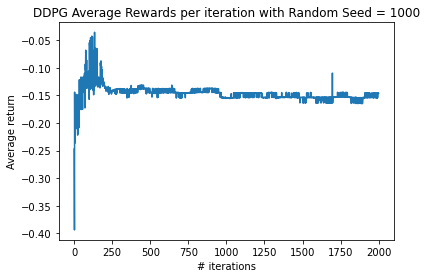

In [9]:
# plot for the return after each policy update.
plt.figure()
plt.plot(average_reward)
plt.xlabel('# iterations')
plt.ylabel('Average return')
plt.title('DDPG Average Rewards per iteration with Random Seed = {}'.format(1000))
plt.show()

In [10]:
with open('ddpg_reach_1000.pkl', 'wb') as pickle_file:
    pickle.dump(ddpg_object.actor, pickle_file)
np.save('critic_loss_1000.npy', critic_loss)
np.save('actor_loss_1000.npy', actor_loss)
np.save('eval_step_1000.npy', eval_step)
np.save('average_reward_1000.npy', average_reward)

In [11]:
with open('ddpg_reach_1000.pkl', 'rb') as pickle_file:
    ddpg_object.actor = pickle.load(pickle_file)

env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=True)
state = env.reset()
time.sleep(5)  
step = 0
done = False
while not done:
    action = ddpg_object.actor(torch.FloatTensor(state).to(device)).cpu().detach().squeeze().numpy()
    next_state, r, done, _ = env.step(action)
    time.sleep(0.1)
    state = next_state
    step += 1
    print('Step: {}, action: {}, reward: {}'.format(step, action, r))

Step: 1, action: [-0.56921214 -0.9999858 ], reward: -0.3297375864538431
Step: 2, action: [-0.53761905 -0.9584905 ], reward: -0.31757537303383176
Step: 3, action: [-0.5772971  -0.70424336], reward: -0.278002695622742
Step: 4, action: [-0.5177257 -0.518246 ], reward: -0.2445020794163102
Step: 5, action: [-0.48820934 -0.49671066], reward: -0.23120971500994025
Step: 6, action: [-0.4847828  -0.26555246], reward: -0.19973785275026998
Step: 7, action: [-0.44350392  0.01075388], reward: -0.17078262427415578
Step: 8, action: [-0.38245177  0.20015152], reward: -0.14993404418033154
Step: 9, action: [-0.27920076  0.25237218], reward: -0.12612361066760766
Step: 10, action: [-0.20041719  0.31029025], reward: -0.10747372917041832
Step: 11, action: [-0.22119708  0.27111626], reward: -0.08958356080539069
Step: 12, action: [-0.24505462  0.24285525], reward: -0.07415895791796556
Step: 13, action: [-0.2732998  0.100746 ], reward: -0.056773619118715
Step: 14, action: [-0.26048645  0.03299258], reward: -0.0

## Random Seed 100

In [12]:
np.random.seed(100)
env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
ddpg_object_100 = DDPG(
    env,
    8,
    2,
    critic_lr=1e-3,
    actor_lr=1e-3,
    gamma=0.99,
    batch_size=100,
    )
 
critic_loss, actor_loss, eval_step, average_reward = ddpg_object_100.train(200000)

step 0, critic_loss = 0.0665, actor_loss = 0.0169
step 100, critic_loss = 0.0027, actor_loss = 0.2539
step 200, critic_loss = 0.0017, actor_loss = 0.2871
step 300, critic_loss = 0.0010, actor_loss = 0.3362
step 400, critic_loss = 0.0020, actor_loss = 0.2484
step 500, critic_loss = 0.0013, actor_loss = 0.2853
step 600, critic_loss = 0.0006, actor_loss = 0.2949
step 700, critic_loss = 0.0011, actor_loss = 0.2802
step 800, critic_loss = 0.0030, actor_loss = 0.3265
step 900, critic_loss = 0.0006, actor_loss = 0.3101
step 1000, critic_loss = 0.0004, actor_loss = 0.3215
step 1100, critic_loss = 0.0005, actor_loss = 0.3359
step 1200, critic_loss = 0.0006, actor_loss = 0.3360
step 1300, critic_loss = 0.0004, actor_loss = 0.3420
step 1400, critic_loss = 0.0009, actor_loss = 0.3465
step 1500, critic_loss = 0.0007, actor_loss = 0.3663
step 1600, critic_loss = 0.0012, actor_loss = 0.3903
step 1700, critic_loss = 0.0006, actor_loss = 0.3977
step 1800, critic_loss = 0.0008, actor_loss = 0.4069
step 

step 15400, critic_loss = 0.0008, actor_loss = 1.0916
step 15500, critic_loss = 0.0009, actor_loss = 1.1456
step 15600, critic_loss = 0.0049, actor_loss = 1.2605
step 15700, critic_loss = 0.0014, actor_loss = 1.1208
step 15800, critic_loss = 0.0014, actor_loss = 1.0892
step 15900, critic_loss = 0.0045, actor_loss = 0.9911
step 16000, critic_loss = 0.0010, actor_loss = 1.0526
step 16100, critic_loss = 0.0019, actor_loss = 1.0734
step 16200, critic_loss = 0.0013, actor_loss = 0.9656
step 16300, critic_loss = 0.0029, actor_loss = 1.0345
step 16400, critic_loss = 0.0011, actor_loss = 1.0752
step 16500, critic_loss = 0.0015, actor_loss = 1.2207
step 16600, critic_loss = 0.0023, actor_loss = 1.0584
step 16700, critic_loss = 0.0021, actor_loss = 1.0461
step 16800, critic_loss = 0.0009, actor_loss = 1.1378
step 16900, critic_loss = 0.0019, actor_loss = 1.0303
step 17000, critic_loss = 0.0019, actor_loss = 0.9758
step 17100, critic_loss = 0.0525, actor_loss = 0.8989
step 17200, critic_loss = 0.

step 30600, critic_loss = 0.0002, actor_loss = 0.8641
step 30700, critic_loss = 0.0007, actor_loss = 0.8098
step 30800, critic_loss = 0.0008, actor_loss = 0.7020
step 30900, critic_loss = 0.0002, actor_loss = 0.7248
step 31000, critic_loss = 0.0007, actor_loss = 0.6506
step 31100, critic_loss = 0.0004, actor_loss = 0.6735
step 31200, critic_loss = 0.0001, actor_loss = 0.7026
step 31300, critic_loss = 0.0005, actor_loss = 0.8931
step 31400, critic_loss = 0.0006, actor_loss = 0.8296
step 31500, critic_loss = 0.0015, actor_loss = 0.6200
step 31600, critic_loss = 0.0004, actor_loss = 0.8556
step 31700, critic_loss = 0.0003, actor_loss = 0.7120
step 31800, critic_loss = 0.0004, actor_loss = 0.7017
step 31900, critic_loss = 0.0010, actor_loss = 0.7273
step 32000, critic_loss = 0.0013, actor_loss = 0.7964
step 32100, critic_loss = 0.0006, actor_loss = 0.8297
step 32200, critic_loss = 0.0003, actor_loss = 0.7500
step 32300, critic_loss = 0.0003, actor_loss = 0.6640
step 32400, critic_loss = 0.

step 45800, critic_loss = 0.0001, actor_loss = 0.8461
step 45900, critic_loss = 0.0002, actor_loss = 0.7960
step 46000, critic_loss = 0.0001, actor_loss = 0.6068
step 46100, critic_loss = 0.0008, actor_loss = 0.8225
step 46200, critic_loss = 0.0002, actor_loss = 0.6637
step 46300, critic_loss = 0.0005, actor_loss = 0.7380
step 46400, critic_loss = 0.0002, actor_loss = 0.8351
step 46500, critic_loss = 0.0002, actor_loss = 0.7127
step 46600, critic_loss = 0.0001, actor_loss = 0.8074
step 46700, critic_loss = 0.0003, actor_loss = 0.9132
step 46800, critic_loss = 0.0004, actor_loss = 0.6523
step 46900, critic_loss = 0.0003, actor_loss = 0.7525
step 47000, critic_loss = 0.0010, actor_loss = 0.7962
step 47100, critic_loss = 0.0001, actor_loss = 0.7664
step 47200, critic_loss = 0.0005, actor_loss = 0.7023
step 47300, critic_loss = 0.0004, actor_loss = 0.7855
step 47400, critic_loss = 0.0001, actor_loss = 0.8018
step 47500, critic_loss = 0.0002, actor_loss = 0.7765
step 47600, critic_loss = 0.

step 61000, critic_loss = 0.0001, actor_loss = 0.8433
step 61100, critic_loss = 0.0002, actor_loss = 0.8166
step 61200, critic_loss = 0.0001, actor_loss = 0.7375
step 61300, critic_loss = 0.0003, actor_loss = 0.7776
step 61400, critic_loss = 0.0039, actor_loss = 0.7420
step 61500, critic_loss = 0.0006, actor_loss = 0.7058
step 61600, critic_loss = 0.0007, actor_loss = 0.6651
step 61700, critic_loss = 0.0003, actor_loss = 0.7386
step 61800, critic_loss = 0.0004, actor_loss = 0.8084
step 61900, critic_loss = 0.0004, actor_loss = 0.8109
step 62000, critic_loss = 0.0001, actor_loss = 0.7961
step 62100, critic_loss = 0.0003, actor_loss = 0.7337
step 62200, critic_loss = 0.0003, actor_loss = 0.8355
step 62300, critic_loss = 0.0011, actor_loss = 0.7645
step 62400, critic_loss = 0.0002, actor_loss = 0.7315
step 62500, critic_loss = 0.0001, actor_loss = 0.8163
step 62600, critic_loss = 0.0032, actor_loss = 0.7549
step 62700, critic_loss = 0.0001, actor_loss = 0.7973
step 62800, critic_loss = 0.

step 76200, critic_loss = 0.0002, actor_loss = 0.6940
step 76300, critic_loss = 0.0020, actor_loss = 0.7016
step 76400, critic_loss = 0.0001, actor_loss = 0.7666
step 76500, critic_loss = 0.0006, actor_loss = 0.7380
step 76600, critic_loss = 0.0013, actor_loss = 0.8395
step 76700, critic_loss = 0.0003, actor_loss = 0.8291
step 76800, critic_loss = 0.0029, actor_loss = 0.6843
step 76900, critic_loss = 0.0005, actor_loss = 0.7134
step 77000, critic_loss = 0.0003, actor_loss = 0.7127
step 77100, critic_loss = 0.0003, actor_loss = 0.7337
step 77200, critic_loss = 0.0042, actor_loss = 0.7252
step 77300, critic_loss = 0.0004, actor_loss = 0.7698
step 77400, critic_loss = 0.0014, actor_loss = 0.8722
step 77500, critic_loss = 0.0003, actor_loss = 0.7775
step 77600, critic_loss = 0.0006, actor_loss = 0.7225
step 77700, critic_loss = 0.0014, actor_loss = 0.6958
step 77800, critic_loss = 0.0021, actor_loss = 0.8333
step 77900, critic_loss = 0.0024, actor_loss = 0.7461
step 78000, critic_loss = 0.

step 91400, critic_loss = 0.0038, actor_loss = 0.7425
step 91500, critic_loss = 0.0017, actor_loss = 0.8104
step 91600, critic_loss = 0.0005, actor_loss = 0.7464
step 91700, critic_loss = 0.0004, actor_loss = 0.6952
step 91800, critic_loss = 0.0004, actor_loss = 0.7904
step 91900, critic_loss = 0.0006, actor_loss = 0.7769
step 92000, critic_loss = 0.0004, actor_loss = 0.7204
step 92100, critic_loss = 0.0007, actor_loss = 0.7451
step 92200, critic_loss = 0.0005, actor_loss = 0.6338
step 92300, critic_loss = 0.0004, actor_loss = 0.7776
step 92400, critic_loss = 0.0093, actor_loss = 0.7495
step 92500, critic_loss = 0.0007, actor_loss = 0.7653
step 92600, critic_loss = 0.0007, actor_loss = 0.6914
step 92700, critic_loss = 0.0007, actor_loss = 0.7443
step 92800, critic_loss = 0.0005, actor_loss = 0.6842
step 92900, critic_loss = 0.0014, actor_loss = 0.6811
step 93000, critic_loss = 0.0013, actor_loss = 0.7690
step 93100, critic_loss = 0.0002, actor_loss = 0.6738
step 93200, critic_loss = 0.

step 106500, critic_loss = 0.0004, actor_loss = 0.8573
step 106600, critic_loss = 0.0013, actor_loss = 0.6359
step 106700, critic_loss = 0.0009, actor_loss = 0.7484
step 106800, critic_loss = 0.0004, actor_loss = 0.6366
step 106900, critic_loss = 0.0001, actor_loss = 0.7358
step 107000, critic_loss = 0.0038, actor_loss = 0.6525
step 107100, critic_loss = 0.0004, actor_loss = 0.6664
step 107200, critic_loss = 0.0009, actor_loss = 0.7059
step 107300, critic_loss = 0.0003, actor_loss = 0.8140
step 107400, critic_loss = 0.0002, actor_loss = 0.7380
step 107500, critic_loss = 0.0011, actor_loss = 0.7575
step 107600, critic_loss = 0.0014, actor_loss = 0.7586
step 107700, critic_loss = 0.0003, actor_loss = 0.7353
step 107800, critic_loss = 0.0008, actor_loss = 0.7846
step 107900, critic_loss = 0.0004, actor_loss = 0.7657
step 108000, critic_loss = 0.0002, actor_loss = 0.7873
step 108100, critic_loss = 0.0005, actor_loss = 0.8278
step 108200, critic_loss = 0.0003, actor_loss = 0.7354
step 10830

step 121400, critic_loss = 0.0015, actor_loss = 0.6132
step 121500, critic_loss = 0.0009, actor_loss = 0.7351
step 121600, critic_loss = 0.0021, actor_loss = 0.7173
step 121700, critic_loss = 0.0011, actor_loss = 0.7371
step 121800, critic_loss = 0.0008, actor_loss = 0.7331
step 121900, critic_loss = 0.0017, actor_loss = 0.7223
step 122000, critic_loss = 0.0015, actor_loss = 0.7400
step 122100, critic_loss = 0.0013, actor_loss = 0.7132
step 122200, critic_loss = 0.0008, actor_loss = 0.6680
step 122300, critic_loss = 0.0115, actor_loss = 0.6591
step 122400, critic_loss = 0.0015, actor_loss = 0.6567
step 122500, critic_loss = 0.0019, actor_loss = 0.6686
step 122600, critic_loss = 0.0027, actor_loss = 0.6597
step 122700, critic_loss = 0.0015, actor_loss = 0.6628
step 122800, critic_loss = 0.0009, actor_loss = 0.7292
step 122900, critic_loss = 0.0012, actor_loss = 0.5346
step 123000, critic_loss = 0.0024, actor_loss = 0.5705
step 123100, critic_loss = 0.0015, actor_loss = 0.5960
step 12320

step 136300, critic_loss = 0.0002, actor_loss = 0.6284
step 136400, critic_loss = 0.0001, actor_loss = 0.7766
step 136500, critic_loss = 0.0002, actor_loss = 0.7222
step 136600, critic_loss = 0.0001, actor_loss = 0.6448
step 136700, critic_loss = 0.0001, actor_loss = 0.8113
step 136800, critic_loss = 0.0015, actor_loss = 0.6235
step 136900, critic_loss = 0.0014, actor_loss = 0.6599
step 137000, critic_loss = 0.0003, actor_loss = 0.7335
step 137100, critic_loss = 0.0003, actor_loss = 0.7328
step 137200, critic_loss = 0.0007, actor_loss = 0.7328
step 137300, critic_loss = 0.0001, actor_loss = 0.8481
step 137400, critic_loss = 0.0007, actor_loss = 0.7101
step 137500, critic_loss = 0.0006, actor_loss = 0.7439
step 137600, critic_loss = 0.0001, actor_loss = 0.8163
step 137700, critic_loss = 0.0001, actor_loss = 0.7229
step 137800, critic_loss = 0.0003, actor_loss = 0.7972
step 137900, critic_loss = 0.0002, actor_loss = 0.7393
step 138000, critic_loss = 0.0003, actor_loss = 0.7042
step 13810

step 151200, critic_loss = 0.0002, actor_loss = 0.8940
step 151300, critic_loss = 0.0001, actor_loss = 0.7073
step 151400, critic_loss = 0.0005, actor_loss = 0.8078
step 151500, critic_loss = 0.0002, actor_loss = 0.8757
step 151600, critic_loss = 0.0008, actor_loss = 0.7294
step 151700, critic_loss = 0.0003, actor_loss = 0.8763
step 151800, critic_loss = 0.0012, actor_loss = 0.8256
step 151900, critic_loss = 0.0005, actor_loss = 0.6303
step 152000, critic_loss = 0.0057, actor_loss = 0.6915
step 152100, critic_loss = 0.0004, actor_loss = 0.8297
step 152200, critic_loss = 0.0002, actor_loss = 0.7550
step 152300, critic_loss = 0.0009, actor_loss = 0.8792
step 152400, critic_loss = 0.0008, actor_loss = 0.7315
step 152500, critic_loss = 0.0044, actor_loss = 0.8192
step 152600, critic_loss = 0.0002, actor_loss = 0.7479
step 152700, critic_loss = 0.0004, actor_loss = 0.7512
step 152800, critic_loss = 0.0002, actor_loss = 0.6518
step 152900, critic_loss = 0.0015, actor_loss = 0.6403
step 15300

step 166100, critic_loss = 0.0007, actor_loss = 0.7275
step 166200, critic_loss = 0.0005, actor_loss = 0.6548
step 166300, critic_loss = 0.0006, actor_loss = 0.7760
step 166400, critic_loss = 0.0005, actor_loss = 0.6369
step 166500, critic_loss = 0.0042, actor_loss = 0.6711
step 166600, critic_loss = 0.0022, actor_loss = 0.7987
step 166700, critic_loss = 0.0016, actor_loss = 0.8663
step 166800, critic_loss = 0.0004, actor_loss = 0.7665
step 166900, critic_loss = 0.0021, actor_loss = 0.7085
step 167000, critic_loss = 0.0004, actor_loss = 0.7991
step 167100, critic_loss = 0.0007, actor_loss = 0.8018
step 167200, critic_loss = 0.0003, actor_loss = 0.7350
step 167300, critic_loss = 0.0002, actor_loss = 0.7354
step 167400, critic_loss = 0.0015, actor_loss = 0.7316
step 167500, critic_loss = 0.0002, actor_loss = 0.8208
step 167600, critic_loss = 0.0002, actor_loss = 0.8587
step 167700, critic_loss = 0.0014, actor_loss = 0.7186
step 167800, critic_loss = 0.0003, actor_loss = 0.7499
step 16790

step 181000, critic_loss = 0.0005, actor_loss = 0.4930
step 181100, critic_loss = 0.0011, actor_loss = 0.6820
step 181200, critic_loss = 0.0004, actor_loss = 0.8063
step 181300, critic_loss = 0.0004, actor_loss = 0.7247
step 181400, critic_loss = 0.0016, actor_loss = 0.7120
step 181500, critic_loss = 0.0004, actor_loss = 0.7452
step 181600, critic_loss = 0.0026, actor_loss = 0.6796
step 181700, critic_loss = 0.0006, actor_loss = 0.7657
step 181800, critic_loss = 0.0031, actor_loss = 0.7910
step 181900, critic_loss = 0.0001, actor_loss = 0.8645
step 182000, critic_loss = 0.0018, actor_loss = 0.6663
step 182100, critic_loss = 0.0005, actor_loss = 0.7738
step 182200, critic_loss = 0.0010, actor_loss = 0.6983
step 182300, critic_loss = 0.0002, actor_loss = 0.7022
step 182400, critic_loss = 0.0002, actor_loss = 0.7394
step 182500, critic_loss = 0.0004, actor_loss = 0.6938
step 182600, critic_loss = 0.0002, actor_loss = 0.7392
step 182700, critic_loss = 0.0023, actor_loss = 0.7477
step 18280

step 195900, critic_loss = 0.0004, actor_loss = 0.6391
step 196000, critic_loss = 0.0025, actor_loss = 0.6753
step 196100, critic_loss = 0.0003, actor_loss = 0.7090
step 196200, critic_loss = 0.0002, actor_loss = 0.6787
step 196300, critic_loss = 0.0012, actor_loss = 0.7406
step 196400, critic_loss = 0.0004, actor_loss = 0.7257
step 196500, critic_loss = 0.0002, actor_loss = 0.6841
step 196600, critic_loss = 0.0003, actor_loss = 0.7327
step 196700, critic_loss = 0.0005, actor_loss = 0.6813
step 196800, critic_loss = 0.0009, actor_loss = 0.5806
step 196900, critic_loss = 0.0006, actor_loss = 0.7158
step 197000, critic_loss = 0.0006, actor_loss = 0.6468
step 197100, critic_loss = 0.0006, actor_loss = 0.7509
step 197200, critic_loss = 0.0012, actor_loss = 0.7181
step 197300, critic_loss = 0.0004, actor_loss = 0.7236
step 197400, critic_loss = 0.0005, actor_loss = 0.6515
step 197500, critic_loss = 0.0006, actor_loss = 0.6898
step 197600, critic_loss = 0.0005, actor_loss = 0.7058
step 19770

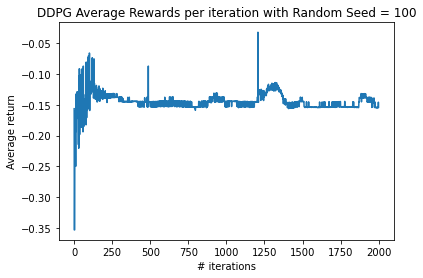

In [13]:
# plot for the return after each policy update.
plt.figure()
plt.plot(average_reward)
plt.xlabel('# iterations')
plt.ylabel('Average return')
plt.title('DDPG Average Rewards per iteration with Random Seed = {}'.format(100))
plt.show()

In [14]:
with open('ddpg_reach_100.pkl', 'wb') as pickle_file:
    pickle.dump(ddpg_object_100.actor, pickle_file)
np.save('critic_loss_100.npy', critic_loss)
np.save('actor_loss_100.npy', actor_loss)
np.save('eval_step_100.npy', eval_step)
np.save('average_reward_100.npy', average_reward)

In [15]:
with open('ddpg_reach_100.pkl', 'rb') as pickle_file:
    ddpg_object_100.actor = pickle.load(pickle_file)
    
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=True)
state = env.reset()
time.sleep(5)  
step = 0
done = False
while not done:
    action = ddpg_object_100.actor(torch.FloatTensor(state).to(device)).cpu().detach().squeeze().numpy()
    next_state, r, done, _ = env.step(action)
    time.sleep(0.1)
    state = next_state
    step += 1
    print('Step: {}, action: {}, reward: {}'.format(step, action, r))

Step: 1, action: [-0.67702585 -0.9999893 ], reward: -0.3431744327581406
Step: 2, action: [-0.59289503 -0.99968344], reward: -0.33171638799971337
Step: 3, action: [-0.49837506 -0.6933953 ], reward: -0.26759944222770726
Step: 4, action: [-0.48713508 -0.7676156 ], reward: -0.27301226190483235
Step: 5, action: [-0.5324679  -0.32497135], reward: -0.22031641104673036
Step: 6, action: [-0.5190202 -0.2983555], reward: -0.2029536432949817
Step: 7, action: [-0.5571263  -0.01016031], reward: -0.17911767234925602
Step: 8, action: [-0.5660825   0.21071333], reward: -0.1637939671969183
Step: 9, action: [-0.5639332   0.29755598], reward: -0.1478331705740406
Step: 10, action: [-0.5343849   0.33011815], reward: -0.12792067400875728
Step: 11, action: [-0.24897625  0.16909815], reward: -0.08031908381859083
Step: 12, action: [-0.0425944   0.08446746], reward: -0.05583388313055701
Step: 13, action: [0.07416528 0.03854114], reward: -0.0400493855456889
Step: 14, action: [-0.20485604  0.07201225], reward: -0.

## Random Seed: 2000

In [16]:
np.random.seed(2000)
env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
ddpg_object_2000 = DDPG(
    env,
    8,
    2,
    critic_lr=1e-3,
    actor_lr=1e-3,
    gamma=0.99,
    batch_size=100,
    )
 
critic_loss, actor_loss, eval_step, average_reward = ddpg_object_2000.train(200000)

step 0, critic_loss = 0.0687, actor_loss = 0.0208
step 100, critic_loss = 0.0020, actor_loss = 0.2601
step 200, critic_loss = 0.0018, actor_loss = 0.2828
step 300, critic_loss = 0.0016, actor_loss = 0.2850
step 400, critic_loss = 0.0008, actor_loss = 0.2661
step 500, critic_loss = 0.0008, actor_loss = 0.2574
step 600, critic_loss = 0.0009, actor_loss = 0.2721
step 700, critic_loss = 0.0005, actor_loss = 0.2731
step 800, critic_loss = 0.0002, actor_loss = 0.2841
step 900, critic_loss = 0.0004, actor_loss = 0.3102
step 1000, critic_loss = 0.0013, actor_loss = 0.3307
step 1100, critic_loss = 0.0007, actor_loss = 0.3103
step 1200, critic_loss = 0.0002, actor_loss = 0.3247
step 1300, critic_loss = 0.0002, actor_loss = 0.3288
step 1400, critic_loss = 0.0011, actor_loss = 0.3793
step 1500, critic_loss = 0.0003, actor_loss = 0.3700
step 1600, critic_loss = 0.0014, actor_loss = 0.3835
step 1700, critic_loss = 0.0006, actor_loss = 0.3854
step 1800, critic_loss = 0.0017, actor_loss = 0.4299
step 

step 15400, critic_loss = 0.0024, actor_loss = 1.0677
step 15500, critic_loss = 0.0016, actor_loss = 0.9197
step 15600, critic_loss = 0.0024, actor_loss = 0.9531
step 15700, critic_loss = 0.0050, actor_loss = 0.9637
step 15800, critic_loss = 0.0012, actor_loss = 0.9389
step 15900, critic_loss = 0.0032, actor_loss = 0.8861
step 16000, critic_loss = 0.0018, actor_loss = 0.8619
step 16100, critic_loss = 0.0014, actor_loss = 0.9470
step 16200, critic_loss = 0.0237, actor_loss = 0.8862
step 16300, critic_loss = 0.0033, actor_loss = 0.9486
step 16400, critic_loss = 0.0014, actor_loss = 0.9861
step 16500, critic_loss = 0.0026, actor_loss = 0.9698
step 16600, critic_loss = 0.0014, actor_loss = 0.8536
step 16700, critic_loss = 0.0016, actor_loss = 0.8095
step 16800, critic_loss = 0.0013, actor_loss = 0.8840
step 16900, critic_loss = 0.0162, actor_loss = 0.9131
step 17000, critic_loss = 0.0030, actor_loss = 0.9027
step 17100, critic_loss = 0.0011, actor_loss = 0.7966
step 17200, critic_loss = 0.

step 30600, critic_loss = 0.0007, actor_loss = 0.8294
step 30700, critic_loss = 0.0005, actor_loss = 0.7245
step 30800, critic_loss = 0.0003, actor_loss = 0.7623
step 30900, critic_loss = 0.0012, actor_loss = 0.6714
step 31000, critic_loss = 0.0001, actor_loss = 0.8176
step 31100, critic_loss = 0.0006, actor_loss = 0.6263
step 31200, critic_loss = 0.0027, actor_loss = 0.7733
step 31300, critic_loss = 0.0001, actor_loss = 0.8141
step 31400, critic_loss = 0.0008, actor_loss = 0.9195
step 31500, critic_loss = 0.0005, actor_loss = 0.7950
step 31600, critic_loss = 0.0001, actor_loss = 0.6806
step 31700, critic_loss = 0.0004, actor_loss = 0.7783
step 31800, critic_loss = 0.0005, actor_loss = 0.8446
step 31900, critic_loss = 0.0005, actor_loss = 0.7420
step 32000, critic_loss = 0.0005, actor_loss = 0.7347
step 32100, critic_loss = 0.0001, actor_loss = 0.8308
step 32200, critic_loss = 0.0002, actor_loss = 0.9333
step 32300, critic_loss = 0.0001, actor_loss = 0.8098
step 32400, critic_loss = 0.

step 45800, critic_loss = 0.0002, actor_loss = 0.8304
step 45900, critic_loss = 0.0008, actor_loss = 0.8607
step 46000, critic_loss = 0.0002, actor_loss = 0.7555
step 46100, critic_loss = 0.0001, actor_loss = 0.7830
step 46200, critic_loss = 0.0003, actor_loss = 0.7456
step 46300, critic_loss = 0.0002, actor_loss = 0.7470
step 46400, critic_loss = 0.0007, actor_loss = 0.8054
step 46500, critic_loss = 0.0005, actor_loss = 0.7697
step 46600, critic_loss = 0.0003, actor_loss = 0.7715
step 46700, critic_loss = 0.0002, actor_loss = 0.7572
step 46800, critic_loss = 0.0001, actor_loss = 0.8405
step 46900, critic_loss = 0.0011, actor_loss = 0.8154
step 47000, critic_loss = 0.0003, actor_loss = 0.7270
step 47100, critic_loss = 0.0003, actor_loss = 0.7394
step 47200, critic_loss = 0.0007, actor_loss = 0.8486
step 47300, critic_loss = 0.0002, actor_loss = 0.7905
step 47400, critic_loss = 0.0021, actor_loss = 0.6861
step 47500, critic_loss = 0.0002, actor_loss = 0.7634
step 47600, critic_loss = 0.

step 61000, critic_loss = 0.0003, actor_loss = 0.8100
step 61100, critic_loss = 0.0013, actor_loss = 0.9023
step 61200, critic_loss = 0.0010, actor_loss = 0.7853
step 61300, critic_loss = 0.0004, actor_loss = 0.8200
step 61400, critic_loss = 0.0002, actor_loss = 0.8008
step 61500, critic_loss = 0.0047, actor_loss = 0.7874
step 61600, critic_loss = 0.0007, actor_loss = 0.6734
step 61700, critic_loss = 0.0022, actor_loss = 0.9472
step 61800, critic_loss = 0.0004, actor_loss = 0.8020
step 61900, critic_loss = 0.0019, actor_loss = 0.6984
step 62000, critic_loss = 0.0004, actor_loss = 0.8009
step 62100, critic_loss = 0.0008, actor_loss = 0.7796
step 62200, critic_loss = 0.0025, actor_loss = 0.8109
step 62300, critic_loss = 0.0177, actor_loss = 0.8408
step 62400, critic_loss = 0.0013, actor_loss = 0.7984
step 62500, critic_loss = 0.0002, actor_loss = 0.8757
step 62600, critic_loss = 0.0005, actor_loss = 0.8367
step 62700, critic_loss = 0.0006, actor_loss = 0.8370
step 62800, critic_loss = 0.

step 76200, critic_loss = 0.0005, actor_loss = 0.6488
step 76300, critic_loss = 0.0003, actor_loss = 0.8862
step 76400, critic_loss = 0.0003, actor_loss = 0.8622
step 76500, critic_loss = 0.0013, actor_loss = 0.7554
step 76600, critic_loss = 0.0003, actor_loss = 0.7760
step 76700, critic_loss = 0.0003, actor_loss = 0.6846
step 76800, critic_loss = 0.0006, actor_loss = 0.6738
step 76900, critic_loss = 0.0002, actor_loss = 0.7645
step 77000, critic_loss = 0.0025, actor_loss = 0.8322
step 77100, critic_loss = 0.0001, actor_loss = 0.6680
step 77200, critic_loss = 0.0001, actor_loss = 0.6962
step 77300, critic_loss = 0.0001, actor_loss = 0.8134
step 77400, critic_loss = 0.0002, actor_loss = 0.7338
step 77500, critic_loss = 0.0003, actor_loss = 0.8328
step 77600, critic_loss = 0.0003, actor_loss = 0.7100
step 77700, critic_loss = 0.0020, actor_loss = 0.8745
step 77800, critic_loss = 0.0002, actor_loss = 0.8553
step 77900, critic_loss = 0.0012, actor_loss = 0.5730
step 78000, critic_loss = 0.

step 91400, critic_loss = 0.0008, actor_loss = 0.6024
step 91500, critic_loss = 0.0017, actor_loss = 0.7742
step 91600, critic_loss = 0.0055, actor_loss = 0.7202
step 91700, critic_loss = 0.0008, actor_loss = 0.5843
step 91800, critic_loss = 0.0034, actor_loss = 0.7726
step 91900, critic_loss = 0.0013, actor_loss = 0.8445
step 92000, critic_loss = 0.0012, actor_loss = 0.6195
step 92100, critic_loss = 0.0016, actor_loss = 0.7314
step 92200, critic_loss = 0.0007, actor_loss = 0.6805
step 92300, critic_loss = 0.0021, actor_loss = 0.7516
step 92400, critic_loss = 0.0011, actor_loss = 0.6142
step 92500, critic_loss = 0.0014, actor_loss = 0.7147
step 92600, critic_loss = 0.0003, actor_loss = 0.6760
step 92700, critic_loss = 0.0014, actor_loss = 0.7292
step 92800, critic_loss = 0.0004, actor_loss = 0.8076
step 92900, critic_loss = 0.0004, actor_loss = 0.6932
step 93000, critic_loss = 0.0008, actor_loss = 0.7297
step 93100, critic_loss = 0.0035, actor_loss = 0.5781
step 93200, critic_loss = 0.

step 106500, critic_loss = 0.0006, actor_loss = 0.8270
step 106600, critic_loss = 0.0127, actor_loss = 0.8192
step 106700, critic_loss = 0.0006, actor_loss = 0.8286
step 106800, critic_loss = 0.0016, actor_loss = 0.6625
step 106900, critic_loss = 0.0026, actor_loss = 0.7062
step 107000, critic_loss = 0.0006, actor_loss = 0.7065
step 107100, critic_loss = 0.0017, actor_loss = 0.7364
step 107200, critic_loss = 0.0007, actor_loss = 0.5892
step 107300, critic_loss = 0.0031, actor_loss = 0.6242
step 107400, critic_loss = 0.0008, actor_loss = 0.8271
step 107500, critic_loss = 0.0057, actor_loss = 0.6462
step 107600, critic_loss = 0.0006, actor_loss = 0.8062
step 107700, critic_loss = 0.0003, actor_loss = 0.7818
step 107800, critic_loss = 0.0005, actor_loss = 0.6545
step 107900, critic_loss = 0.0005, actor_loss = 0.6730
step 108000, critic_loss = 0.0005, actor_loss = 0.7657
step 108100, critic_loss = 0.0251, actor_loss = 0.7657
step 108200, critic_loss = 0.0006, actor_loss = 0.7139
step 10830

step 121400, critic_loss = 0.0020, actor_loss = 0.7249
step 121500, critic_loss = 0.0007, actor_loss = 0.8274
step 121600, critic_loss = 0.0003, actor_loss = 0.7696
step 121700, critic_loss = 0.0003, actor_loss = 0.7607
step 121800, critic_loss = 0.0009, actor_loss = 0.8270
step 121900, critic_loss = 0.0018, actor_loss = 0.7111
step 122000, critic_loss = 0.0049, actor_loss = 0.6954
step 122100, critic_loss = 0.0011, actor_loss = 0.7208
step 122200, critic_loss = 0.0004, actor_loss = 0.6945
step 122300, critic_loss = 0.0046, actor_loss = 0.7203
step 122400, critic_loss = 0.0011, actor_loss = 0.7981
step 122500, critic_loss = 0.0005, actor_loss = 0.6227
step 122600, critic_loss = 0.0014, actor_loss = 0.7333
step 122700, critic_loss = 0.0011, actor_loss = 0.6748
step 122800, critic_loss = 0.0010, actor_loss = 0.6717
step 122900, critic_loss = 0.0016, actor_loss = 0.6911
step 123000, critic_loss = 0.0007, actor_loss = 0.6627
step 123100, critic_loss = 0.0005, actor_loss = 0.6802
step 12320

step 136300, critic_loss = 0.0001, actor_loss = 0.7480
step 136400, critic_loss = 0.0004, actor_loss = 0.7046
step 136500, critic_loss = 0.0006, actor_loss = 0.7055
step 136600, critic_loss = 0.0029, actor_loss = 0.6444
step 136700, critic_loss = 0.0006, actor_loss = 0.8350
step 136800, critic_loss = 0.0001, actor_loss = 0.7659
step 136900, critic_loss = 0.0008, actor_loss = 0.8552
step 137000, critic_loss = 0.0003, actor_loss = 0.7103
step 137100, critic_loss = 0.0002, actor_loss = 0.7534
step 137200, critic_loss = 0.0003, actor_loss = 0.8487
step 137300, critic_loss = 0.0003, actor_loss = 0.7077
step 137400, critic_loss = 0.0001, actor_loss = 0.8247
step 137500, critic_loss = 0.0006, actor_loss = 0.6428
step 137600, critic_loss = 0.0002, actor_loss = 0.7276
step 137700, critic_loss = 0.0003, actor_loss = 0.8297
step 137800, critic_loss = 0.0006, actor_loss = 0.7365
step 137900, critic_loss = 0.0006, actor_loss = 0.7335
step 138000, critic_loss = 0.0001, actor_loss = 0.9098
step 13810

step 151200, critic_loss = 0.0005, actor_loss = 0.7795
step 151300, critic_loss = 0.0009, actor_loss = 0.8024
step 151400, critic_loss = 0.0024, actor_loss = 0.8063
step 151500, critic_loss = 0.0003, actor_loss = 0.6763
step 151600, critic_loss = 0.0004, actor_loss = 0.7937
step 151700, critic_loss = 0.0004, actor_loss = 0.8510
step 151800, critic_loss = 0.0003, actor_loss = 0.9655
step 151900, critic_loss = 0.0003, actor_loss = 0.7099
step 152000, critic_loss = 0.0004, actor_loss = 0.7530
step 152100, critic_loss = 0.0004, actor_loss = 0.6932
step 152200, critic_loss = 0.0014, actor_loss = 0.6030
step 152300, critic_loss = 0.0010, actor_loss = 0.7465
step 152400, critic_loss = 0.0007, actor_loss = 0.6608
step 152500, critic_loss = 0.0020, actor_loss = 0.7903
step 152600, critic_loss = 0.0009, actor_loss = 0.7923
step 152700, critic_loss = 0.0006, actor_loss = 0.8133
step 152800, critic_loss = 0.0007, actor_loss = 0.7488
step 152900, critic_loss = 0.0006, actor_loss = 0.7486
step 15300

step 166100, critic_loss = 0.0074, actor_loss = 1.0851
step 166200, critic_loss = 0.0023, actor_loss = 0.9733
step 166300, critic_loss = 0.0023, actor_loss = 0.8572
step 166400, critic_loss = 0.0043, actor_loss = 0.8132
step 166500, critic_loss = 0.0009, actor_loss = 0.6735
step 166600, critic_loss = 0.0014, actor_loss = 0.8141
step 166700, critic_loss = 0.0046, actor_loss = 0.6588
step 166800, critic_loss = 0.0025, actor_loss = 1.0097
step 166900, critic_loss = 0.0016, actor_loss = 0.8325
step 167000, critic_loss = 0.0031, actor_loss = 0.8306
step 167100, critic_loss = 0.0025, actor_loss = 0.8328
step 167200, critic_loss = 0.0073, actor_loss = 0.9894
step 167300, critic_loss = 0.0019, actor_loss = 0.7407
step 167400, critic_loss = 0.0040, actor_loss = 0.9430
step 167500, critic_loss = 0.0087, actor_loss = 0.8859
step 167600, critic_loss = 0.0029, actor_loss = 0.9694
step 167700, critic_loss = 0.0088, actor_loss = 0.7903
step 167800, critic_loss = 0.0047, actor_loss = 0.9365
step 16790

step 181000, critic_loss = 0.0004, actor_loss = 0.7705
step 181100, critic_loss = 0.0002, actor_loss = 0.8304
step 181200, critic_loss = 0.0004, actor_loss = 0.8714
step 181300, critic_loss = 0.0002, actor_loss = 0.7723
step 181400, critic_loss = 0.0008, actor_loss = 0.6809
step 181500, critic_loss = 0.0003, actor_loss = 0.8668
step 181600, critic_loss = 0.0005, actor_loss = 0.8217
step 181700, critic_loss = 0.0004, actor_loss = 0.8030
step 181800, critic_loss = 0.0019, actor_loss = 0.7023
step 181900, critic_loss = 0.0005, actor_loss = 0.5730
step 182000, critic_loss = 0.0003, actor_loss = 0.6380
step 182100, critic_loss = 0.0002, actor_loss = 0.8219
step 182200, critic_loss = 0.0003, actor_loss = 0.9468
step 182300, critic_loss = 0.0005, actor_loss = 0.7234
step 182400, critic_loss = 0.0007, actor_loss = 0.7563
step 182500, critic_loss = 0.0001, actor_loss = 0.8405
step 182600, critic_loss = 0.0010, actor_loss = 0.6506
step 182700, critic_loss = 0.0010, actor_loss = 0.7590
step 18280

step 195900, critic_loss = 0.0002, actor_loss = 0.8719
step 196000, critic_loss = 0.0009, actor_loss = 0.6405
step 196100, critic_loss = 0.0002, actor_loss = 0.7175
step 196200, critic_loss = 0.0002, actor_loss = 0.7905
step 196300, critic_loss = 0.0010, actor_loss = 0.8422
step 196400, critic_loss = 0.0009, actor_loss = 0.6627
step 196500, critic_loss = 0.0006, actor_loss = 0.6490
step 196600, critic_loss = 0.0006, actor_loss = 0.6922
step 196700, critic_loss = 0.0009, actor_loss = 0.7812
step 196800, critic_loss = 0.0001, actor_loss = 0.7855
step 196900, critic_loss = 0.0012, actor_loss = 0.7544
step 197000, critic_loss = 0.0002, actor_loss = 0.9106
step 197100, critic_loss = 0.0003, actor_loss = 0.8157
step 197200, critic_loss = 0.0004, actor_loss = 0.7995
step 197300, critic_loss = 0.0004, actor_loss = 0.7307
step 197400, critic_loss = 0.0010, actor_loss = 0.7348
step 197500, critic_loss = 0.0010, actor_loss = 0.7114
step 197600, critic_loss = 0.0006, actor_loss = 0.7801
step 19770

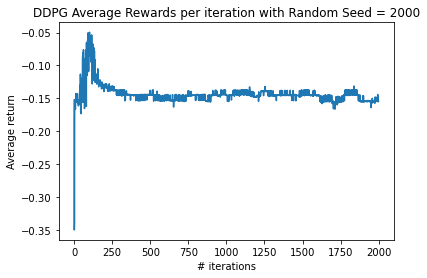

In [17]:
# plot for the return after each policy update.
plt.figure()
plt.plot(average_reward)
plt.xlabel('# iterations')
plt.ylabel('Average return')
plt.title('DDPG Average Rewards per iteration with Random Seed = {}'.format(2000))
plt.show()

In [18]:
with open('ddpg_reach_2000.pkl', 'wb') as pickle_file:
    pickle.dump(ddpg_object_2000.actor, pickle_file)
np.save('critic_loss_2000.npy', critic_loss)
np.save('actor_loss_2000.npy', actor_loss)
np.save('eval_step_2000.npy', eval_step)
np.save('average_reward_2000.npy', average_reward)

In [19]:
with open('ddpg_reach_2000.pkl', 'rb') as pickle_file:
    ddpg_object_2000.actor = pickle.load(pickle_file)

env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=True)
state = env.reset()
time.sleep(5)  
step = 0
done = False
while not done:
    action = ddpg_object_2000.actor(torch.FloatTensor(state).to(device)).cpu().detach().squeeze().numpy()
    next_state, r, done, _ = env.step(action)
    time.sleep(0.1)
    state = next_state
    step += 1
    print('Step: {}, action: {}, reward: {}'.format(step, action, r))

Step: 1, action: [-0.5991423 -0.9848148], reward: -0.3302233523547663
Step: 2, action: [-0.5106232  -0.85689604], reward: -0.2962499874294923
Step: 3, action: [-0.4662279  -0.84451663], reward: -0.28813499654234254
Step: 4, action: [-0.46473235 -0.6858805 ], reward: -0.25968306927163254
Step: 5, action: [-0.3901924 -0.5691932], reward: -0.23010494790253316
Step: 6, action: [-0.41718912 -0.32930255], reward: -0.19556795954016729
Step: 7, action: [-0.5004292   0.06691076], reward: -0.17198543330962968
Step: 8, action: [-0.46911687  0.24536118], reward: -0.15233715747937904
Step: 9, action: [-0.3940945   0.39491287], reward: -0.1342812848370021
Step: 10, action: [-0.32194334  0.41583177], reward: -0.11190574624567864
Step: 11, action: [-0.26753584  0.40931004], reward: -0.09161613707562687
Step: 12, action: [-0.21179402  0.4036059 ], reward: -0.07405236763249079
Step: 13, action: [-0.16385382  0.37349334], reward: -0.0571854323339238
Step: 14, action: [-0.11558457  0.36483696], reward: -0

### Comparision with Assignment 3 Q2

As you can see in the results above, we evalute our policy every 100 steps, and we plot the average returns for each policy we calcuted. Note: the X-axis is x200 iterations. For all three random seeds values, we notice that our policy converges after 25000 to 30000 iterations. These results are really good as the policy is able to solve the environment under 20 steps.  

In assignment 3 Q2, we used policy gradient method to train the policy, and we noticed that the policy converges or stabalizes after 350 iterations. This is basically 350000 steps in DDPG. Therefore, we can say that DDPG is more efficients and gives us better results for policy. Moreover, the policy gradient performs better when we increase the batch size and even after that, it doesn't give stable results.

DDPG gave us consistent results for random seed values, which shows that it works and that it give consistent results. 